Substitution
==============

Equality is a fundamental concept of logic.  When two mathematical operations are equal, then one may be substituted for the other.  This is rule is defined by the `substitution` axiom:

In [1]:
from proveit.logic.equality._axioms_ import substitution
from proveit.common import a, b, c, d, x, y, z, fx # we'll use these later
substitution

The English translation of this axiom is: for any function $f$ and any $x, y$ such that $x=y$, $f(x) = f(y)$.  In other words, we may substitute $y$ for $x$ in any function whenever $x=y$.  The equality of $x$ and $y$ transfers to an equality between $f(x)$ and $f(y)$.  This is fundamental to the meaning of equality regardless of what $f$ does (as long as it can act on a single argument).  We may specialize this axiom using any operation for $f$.  For example,

In [2]:
from proveit.logic import Not, Equals
substitution.specialize({fx:Not(x), x:a, y:b}, assumptions=[Equals(a, b)])

There are more convenient ways to apply this substitution rule than manual specialization that was demonstrated in the previous input.  The `Equals` class has the `substitution`, `lhsSubstitute` and `rhsSubstitute` methods for conveniently applying substitution, as we will demonstrate below.  Each of these methods takes a `lambdaMap` argument.  A `lambdaMap` is either a **Lambda** expression or an object with a `lambdaMap` method that returns a **Lambda** expression.  The `proveit.lambda_map` package contains convenient methods/classes for constructing such objects.  We demonstrate the substitution methods and `proveit.lambda_map` below.

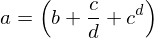

In [3]:
from proveit.lambda_map import globalRepl, SubExprRepl
from proveit.number import Add, Fraction, Exp
expr = Equals(a, Add(b, Fraction(c, d), Exp(c, d)))
expr              

`proveit.lambda_map.globalRepl` is useful for creating a global replacement lambda map.  Below, we create a map for replacing every occurence of $d$ in `expr` with anything else:

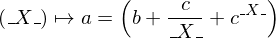

In [4]:
gRepl = globalRepl(expr, d)
gRepl

We now use this lambda map to replace occurences of $d$ in `expr` with $y$:

In [5]:
d_eq_y = Equals(d, y)
d_eq_y

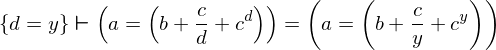

In [6]:
d_eq_y.substitution(gRepl, assumptions=[d_eq_y])

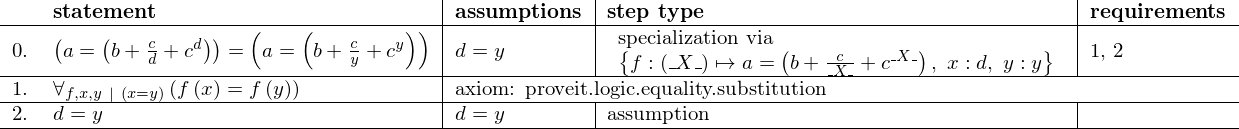

In [7]:
# Now let's look at the proof
d_eq_y.substitution(gRepl, assumptions=[d_eq_y]).proof()

If we want to perform substitution for a specific sub-expression, and not necessarily a global replacement, the `proveit.lambda_map.SubExprRepl` class is extremely convenient.  It uses some Python tricks via implementing the `__getitem__` and `__getattr__` methods.  First, you create the SubExprRepl object by providing a "master" expression:

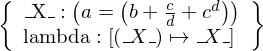

In [8]:
subExprRepl = SubExprRepl(expr)
subExprRepl

The `SubExprMap` object displays itself with two important pieces of information: the lambda map that it represents and the sub-expression of the master expression that would be replaced by this lambda map.  The point is that we will be able to "dig" in to sub-expressions of the master expression via accessing sub-expression attributes.  For example, we next will "dig" into the "right hand side" (`rhs`) of the master expression: 

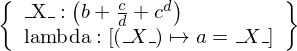

In [9]:
subExprRepl = subExprRepl.rhs
subExprRepl

By accessing the `rhs` attribute, we created a new `SubExprRepl` object that has the same master expression as the original but has a new current sub-expression.  Note that the `SubExprRepl` does not know anything about the `rhs` attribute itself; it is relying on the fact that the previous sub-expression has this attribute.  The `SubExprRepl` class also has tricks for getting an sub-expression with an index (or key):

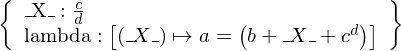

In [10]:
subExprRepl = subExprRepl.operands[1]
subExprRepl

Now will "dig" down to the denominator of $\frac{c}{d}$ and show how we use the `SubExprRepl` class to replace a particular occurence of $d$ rather than a global replacement:

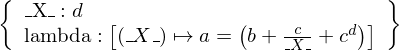

In [11]:
subExprRepl = subExprRepl.denominator
subExprRepl

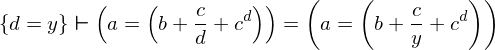

In [12]:
d_eq_y.substitution(subExprRepl, assumptions=[d_eq_y])

Let us demonstrate this technique again, replacing the other occurrence of $d$.  This time we do this more succinctly, without the extra pedogogial steps:

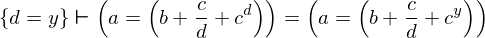

In [13]:
d_eq_y.substitution(SubExprRepl(expr).rhs.operands[2].exponent, assumptions=[d_eq_y])

The `substition` method, that we demonstrated above, is a direct application of the `substitution` axiom.  It proves the equality between some $f(x)$ and some $f(y)$.  We often will want to take a shortcut to perform a statement substitution in which we prove some $P(y)$ is true assuming that $P(x)$ is true and $P(x) = P(y)$.  For this, we have the `rhsSubstitute` and `lhsSubstitute` methods.

If the expression that we want to substitute in is on the right hand side of the `Equals` object playing the role of $x=y$, then we use `rhsSubstitute`: 

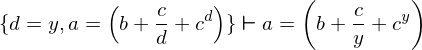

In [14]:
d_eq_y.rhsSubstitute(gRepl, assumptions=[d_eq_y,expr])

If the expression that we want to substitute in is on the left hand side of the `Equals` object playing the role of $x=y$, then we use `rhsSubstitute`: 

In [15]:
y_eq_d = Equals(y, d)
y_eq_d

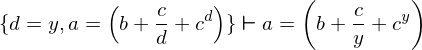

In [16]:
y_eq_d.lhsSubstitute(gRepl, assumptions=[d_eq_y,expr])

Reflexivity, symmetry, and transitivity
=========================

Reflexivity, symmetry, and transitivity are also fundamental properties of equality, in addition to the ability to perform substitution.  Reflexivity is the fact that any mathematical object is equal to itself.  Symmetry is the fact that $x = y$ and $y = x$ have the same logical meaning.  Transitivity is the ability to derive $x=z$ from $x=y$ and $y=z$.  Reflexivity and symmetry are axioms in their own right.  Transitivity is a theorem that derives from substitution.

In [17]:
from proveit.logic.equality._axioms_ import equalsReflexivity, equalsSymmetry 

In [18]:
equalsReflexivity

In [19]:
equalsSymmetry

In [20]:
from  proveit.logic.equality._theorems_ import equalsTransitivity
equalsTransitivity

All three of these are applied automatically for `Equals` objects

Reflexivity is concluded automatically:

In [21]:
Equals(a, a).prove()

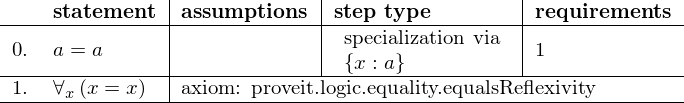

In [22]:
Equals(a, a).prove().proof()

Symmetric statements are derived as side-effects.  Note that the `KnownTruth.deriveSideEffects` method employs a mechanism to prevent infinite recursion or this would not be possible (it would continu.ally go back and forth, proving $y=x$ from $x=y$ then $x=y$ from $y=x$, ad infinitum)

In [23]:
a_eq_b = Equals(a, b)
a_eq_b

In [24]:
Equals(b, a).prove({a_eq_b})

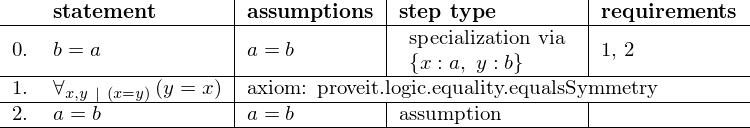

In [25]:
Equals(b, a).prove({a_eq_b}).proof()

Transitivity derivations are attempted with automation via the `conclude` method using the `trensitivitySearch` function in `proveit.logic.equality.transitivity_search`.  This performs a breadth-first, bidirectional search (meeting in the middle from both ends) over the space of **KnownTruth** objects representing equality and using appropriate assumptions.  This is therefore reasonably efficient.  However, this efficiency should never really be an issue as long as proofs for each theorem are relatively small.  A long proof should be broken up into several smaller proofs for lemma-like theorems.  In that case (in the setting of small proofs), the space of **KnownTruth**s will be small and this search algorithm will have ample efficiency. 

In [26]:
# We'll make this interesting by reversing some of the equations in the chain.
c_eq_b = Equals(c, b) 
c_eq_b

In [27]:
c_eq_d = Equals(d, c)
c_eq_d

In [28]:
d_eq_z = Equals(d, z)
d_eq_z

In [29]:
a_eq_z = Equals(a, z).prove(assumptions=[a_eq_b, c_eq_b, c_eq_d, d_eq_z])
a_eq_z

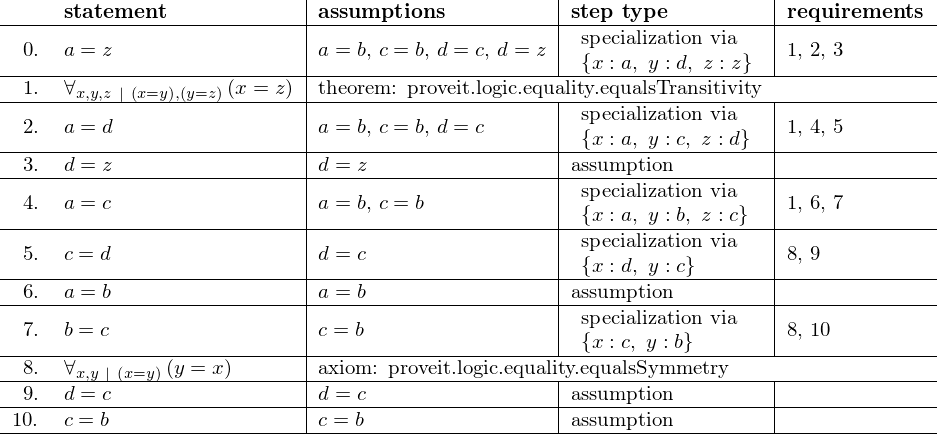

In [30]:
a_eq_z.proof()

Boolean equality
================

Equality with `TRUE` ($\top$) or `FALSE` ($\bot$) has special logical consequences.  The `Equals` object has automation capabilities to treat these special kinds of equations.

In [31]:
from proveit.logic import TRUE, FALSE

In [32]:
TRUE

In [33]:
FALSE

Proofs via boolean equality are automatic via `Equals.deduceSideEffects`:

In [34]:
a.prove([Equals(a, TRUE)])

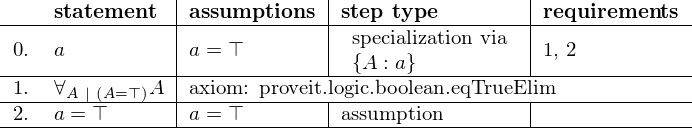

In [35]:
a.prove([Equals(a, TRUE)]).proof()

In [36]:
Not(b).prove([Equals(b, FALSE)])

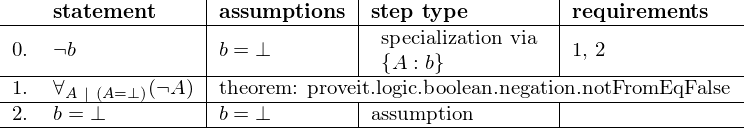

In [37]:
Not(b).prove([Equals(b, FALSE)]).proof()

Going the other direction, boolean equalities are proven automatically via `Equals.conclude`:

In [38]:
Equals(x, TRUE).prove([x])

In [39]:
Equals(TRUE, y).prove([y])

In [40]:
Equals(c, FALSE).prove([Not(c)])

In [41]:
Equals(FALSE, c).prove([Not(c)])

When `FALSE` can be concluded, there is a contradiction.  A contradiction is can be derived from equating something with `FALSE`:

In [42]:
Equals(a, FALSE).deriveContradiction([Equals(a, FALSE)])

In [43]:
Equals(FALSE, b).deriveContradiction([Equals(b, FALSE)])

Equality and set membership (booleans and singleton sets)
===========================

When something is equated to `TRUE` or `FALSE`, we can automatically conclude that it is in the set of `Booleans` ($\mathbb{B}$):

In [44]:
from proveit.logic import inBool
inBool(x) # creates inBool(a).prove([Equals(a, TRUE)])the expression x in Booleans

In [45]:
inBool(a).prove([Equals(a, TRUE)])

In [46]:
inBool(a).prove([a]) # via concluding a boolean equality

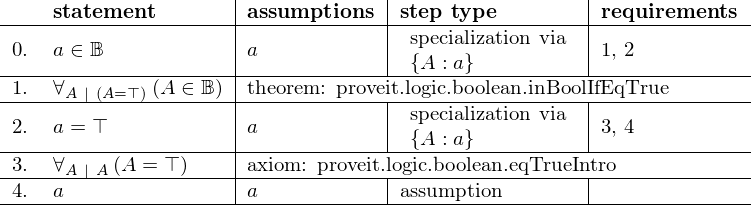

In [47]:
inBool(a).prove([a]).proof()

In [48]:
inBool(a).prove([Equals(a, FALSE)])

In [49]:
inBool(a).prove([Not(a)]) # via concluding a boolean equality

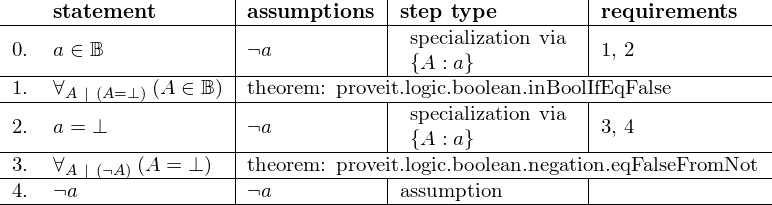

In [50]:
inBool(a).prove([Not(a)]).proof()

A singleton is a set with one element.  If $x=c$, then $x$ is in the singleton set of $\{c\}$:

In [51]:
Equals(x, c).deriveIsInSingleton([Equals(x, c)])

## Evaluation

ToDo